In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

In [89]:
unbalanced = pd.read_csv('./visualization_validation/L2_normalized.csv')
balanced = pd.read_csv('./visualization_validation/Weighted sampling (alpha=0.5)_normalized.csv')

categories = [
    "water", "trees", "grass", "flooded_vegetation", "crops",
    "shrub_and_scrub", "built", "bare"
]

# Test statistically difference between two models for each category intensity

In [71]:
from scipy.stats import mannwhitneyu

In [72]:
def mannwhitneyu_test(unbalanced, df_2, category):
    intensities_model1 = unbalanced[category]  # Intensities from Model 1
    intensities_model2 = df_2[category]  # Intensities from Model 2

    # Perform Mann-Whitney U Test
    stat, p = mannwhitneyu(intensities_model1.dropna(), intensities_model2.dropna())

    print(f'Statistics={stat}, p={p}')
    if p < 0.05:
        print(f"{category}: Statistically significant difference in intensities")
    else:
        print(f"{category}: No significant difference in intensities")

for category in categories:
    mannwhitneyu_test(unbalanced, balanced, category)

Statistics=1135993.0, p=7.986695665667364e-61
water: Statistically significant difference in intensities
Statistics=1187587.0, p=2.692299513976218e-144
trees: Statistically significant difference in intensities
Statistics=1527791.0, p=3.221503394770185e-57
grass: Statistically significant difference in intensities
Statistics=1505654.5, p=4.017253088991098e-57
flooded_vegetation: Statistically significant difference in intensities
Statistics=1441655.0, p=2.526695261117418e-71
crops: Statistically significant difference in intensities
Statistics=1419656.0, p=8.366016346661491e-81
shrub_and_scrub: Statistically significant difference in intensities
Statistics=1328349.5, p=5.044797637203617e-70
built: Statistically significant difference in intensities
Statistics=711779.5, p=6.266697361485718e-22
bare: Statistically significant difference in intensities


# Differences

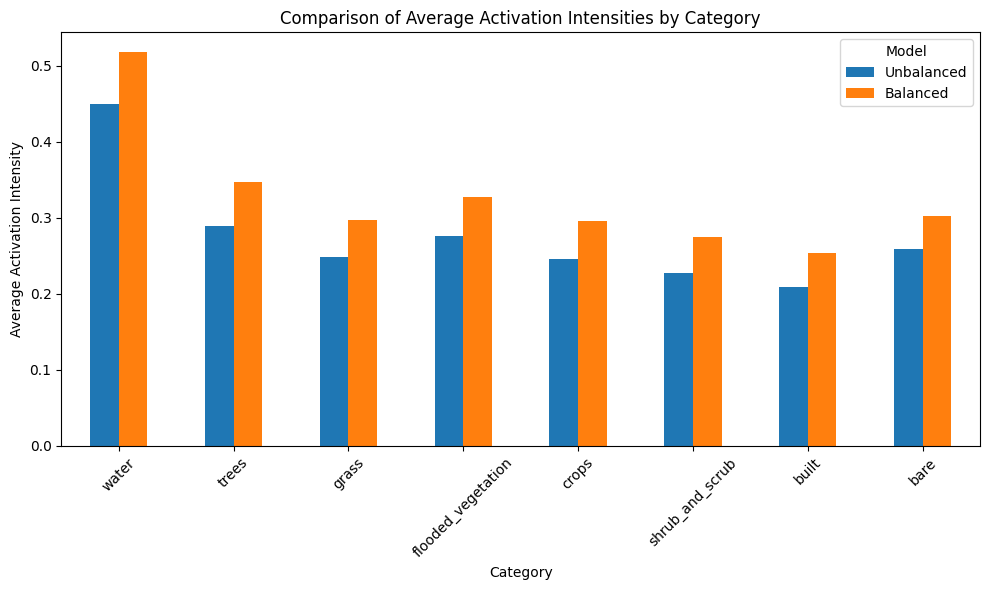

In [73]:
# Example DataFrames: unbalanced and df_2 for the two models
# Calculate mean intensities for each category
mean_intensities_1 = unbalanced[categories].mean()
mean_intensities_2 = balanced[categories].mean()

# Data for plotting
means = pd.DataFrame({
    'Unbalanced': mean_intensities_1,
    'Balanced': mean_intensities_2
})

# Plotting the comparison
means.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Average Activation Intensities by Category')
plt.xlabel('Category')
plt.ylabel('Average Activation Intensity')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Multivariate regression analysis

In [74]:
import xgboost as xgb
import shap
from sklearn.metrics import mean_squared_error, r2_score

In [75]:
def xgboost_analysis(df):

    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
    xg_reg.fit(df[categories], df['Prediction'])

    # Get feature importances
    feature_importances = xg_reg.get_booster().get_score(importance_type='gain')

    # Print the feature importances
    for feature, importance in feature_importances.items():
        print(f"Feature: {feature}, Gain: {importance}")

    y_pred = xg_reg.predict(df[categories])

    # Evaluate the model
    mse = mean_squared_error(df['Prediction'], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(df['Prediction'], y_pred)

    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R^2:", r2)
    
    return xg_reg

In [76]:
xg_reg_unbalanced = xgboost_analysis(unbalanced)

Feature: water, Gain: 0.11753024905920029
Feature: trees, Gain: 0.08563907444477081
Feature: grass, Gain: 0.06773585081100464
Feature: flooded_vegetation, Gain: 0.08904016017913818
Feature: crops, Gain: 0.07513583451509476
Feature: shrub_and_scrub, Gain: 0.06498512625694275
Feature: built, Gain: 0.09724470973014832
Feature: bare, Gain: 0.1182909831404686
MSE: 0.0020328342077036094
RMSE: 0.045086962724313215
R^2: 0.9813271073829295


In [77]:
xg_reg_balanced = xgboost_analysis(balanced)

Feature: water, Gain: 0.1273304671049118
Feature: trees, Gain: 0.1525399535894394
Feature: grass, Gain: 0.08248595893383026
Feature: flooded_vegetation, Gain: 0.1641632467508316
Feature: crops, Gain: 0.06978233903646469
Feature: shrub_and_scrub, Gain: 0.0850958600640297
Feature: built, Gain: 0.09504014253616333
Feature: bare, Gain: 0.13956426084041595
MSE: 0.00314677678568423
RMSE: 0.05609613877696245
R^2: 0.976800880395205


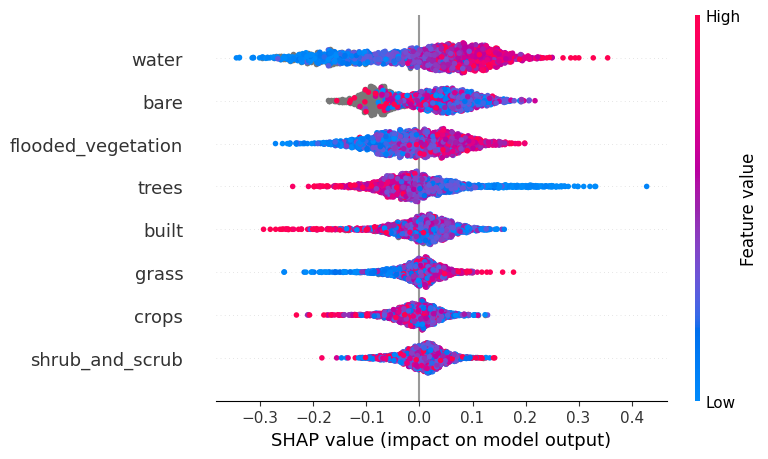

In [78]:
# Calculate SHAP values using the TreeExplainer
explainer = shap.Explainer(xg_reg_unbalanced)
shap_values = explainer.shap_values(unbalanced[categories])

# Summary plot of SHAP values
shap.summary_plot(shap_values, unbalanced[categories], title='Unbalanced')

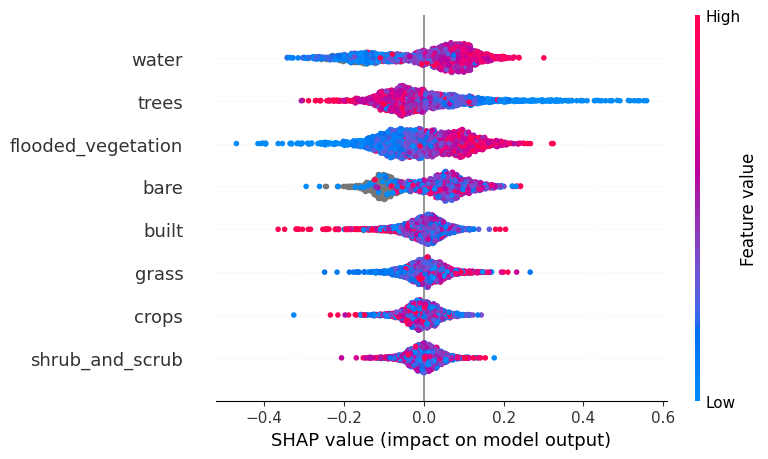

In [79]:
# Calculate SHAP values using the TreeExplainer
explainer = shap.Explainer(xg_reg_balanced)
shap_values = explainer.shap_values(balanced[categories])

# Summary plot of SHAP values
shap.summary_plot(shap_values, balanced[categories])

# Category in lower range

In [80]:
from metrics.balanced_MAE import get_bin_edges

In [95]:
bin_edges = get_bin_edges()
balanced['Bin'] = np.digitize(balanced['Label'], bin_edges, right=True)

In [82]:
def count_unique_values(arr):
    # Find the unique elements and their counts
    unique_values, counts = np.unique(arr, return_counts=True)
    
    # Create a dictionary from unique_values and counts
    value_counts = dict(zip(unique_values, counts))
    
    return value_counts

def sort_bins_by_count(value_counts):
    # Sort the dictionary by values and return the sorted keys
    sorted_keys = sorted(value_counts, key=value_counts.get)
    return sorted_keys

In [97]:
df_1 = balanced.dropna(subset=['trees_area'])
df_2 = balanced.dropna(subset=['flooded_vegetation_area'])
for i in [0,1,2,5,3,4]:
    print(f"Bin index {i}")
    try:
        data_1 = df_1[df_1['Bin'] == i]['trees_area'].mean()/50176
        print(data_1)
    except: 
        print('Bin does not have any sample with trees area')
    try:
        data_2 = df_2[df_2['Bin'] == i]['flooded_vegetation_area'].mean()/50176
        print(data_2)
    except: 
        print('Bin does not have any sample with flooded area')

    

Bin index 0
0.9308178070335277
0.011126548833819243
Bin index 1
0.869114384034864
0.007975260416666668
Bin index 2
0.8433445042680533
0.00827222791159733
Bin index 5
0.3429954215482489
0.01680760267069791
Bin index 3
0.7172587150270758
0.02883748123572534
Bin index 4
0.5020213085234093
0.03074654861944778


In [58]:
for i in [0,1,2,5,3,4]:
    print(balanced[balanced['Bin'] == i]['flooded_vegetation_area'].mean())

558.2857142857143
400.1666666666667
415.0673076923077
843.3382716049383
1446.9494584837546
1542.7388235294118


# Further analysis based on land category clusters

In [12]:
from sklearn.cluster import KMeans
import math

c:\Users\lhmtr\OneDrive\Desktop\remote-sensing-asset-index\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lhmtr\OneDrive\Desktop\remote-sensing-asset-index\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


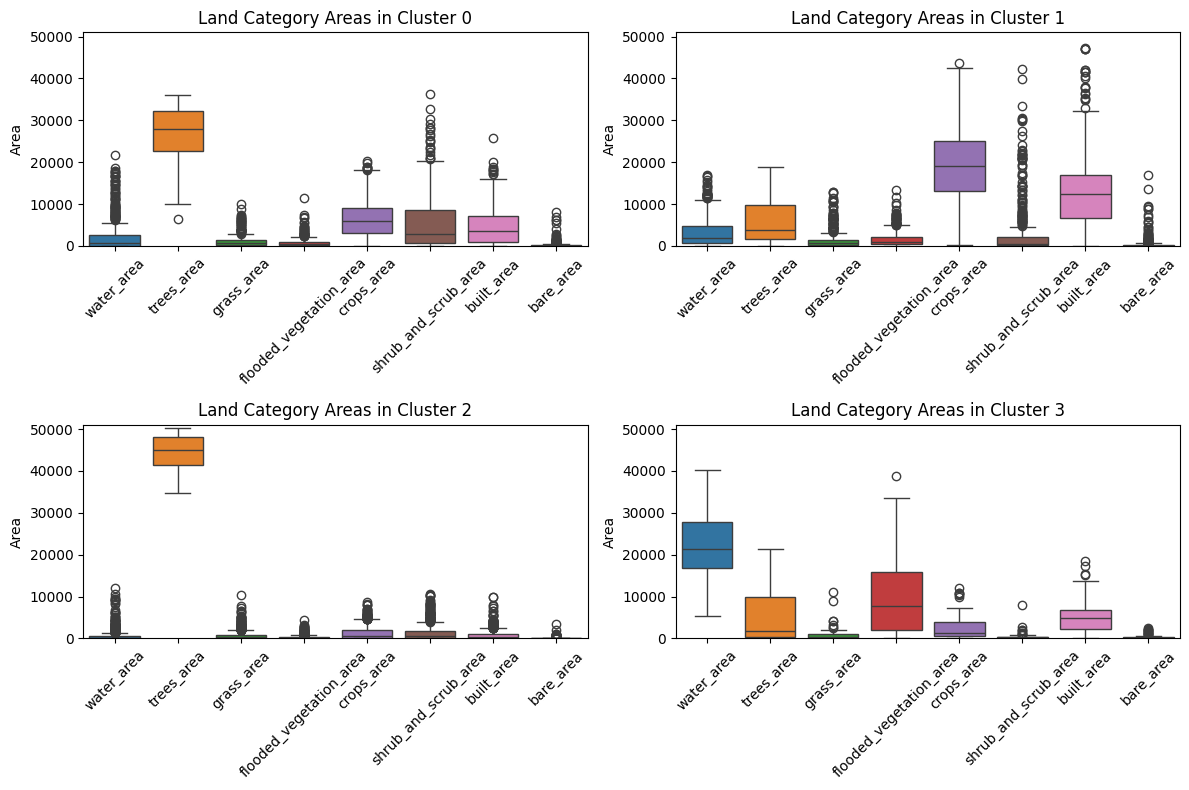

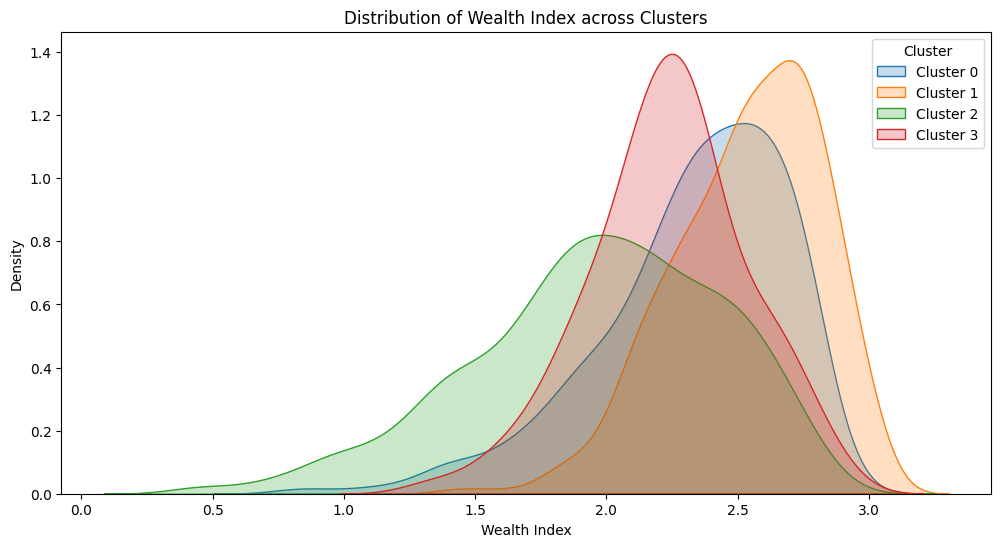

In [13]:
area_columns = [f'{cat}_area' for cat in categories]
unbalanced_cluster = unbalanced.copy()
balanced_cluster = balanced.copy()
for col in area_columns:
    unbalanced_cluster[col] = unbalanced_cluster[col].fillna(0)
    balanced_cluster[col] = balanced_cluster[col].fillna(0)

X = unbalanced_cluster[area_columns]
# Applying KMeans clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
unbalanced_cluster['cluster'] = kmeans.fit_predict(unbalanced_cluster[area_columns])
balanced_cluster['cluster'] = kmeans.fit_predict(balanced_cluster[area_columns])

# Calculate the grid size required: you might want 2 columns or more depending on your preference
num_columns = 2  # you can set this to any number you prefer
num_rows = math.ceil(k / num_columns)

# Set up the matplotlib figure
plt.figure(figsize=(12, 4 * num_rows))  # Adjust the height based on the number of rows

# Iterate through each cluster
for cluster_id in range(k):
    plt.subplot(num_rows, num_columns, cluster_id + 1)
    cluster_data = unbalanced_cluster[unbalanced_cluster['cluster'] == cluster_id]
    sns.boxplot(data=cluster_data[area_columns])
    plt.xticks(rotation=45)
    plt.title(f'Land Category Areas in Cluster {cluster_id}')
    plt.ylabel('Area')
    plt.ylim(0,51000)
    plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 6))
# Generate a KDE plot for each cluster
for cluster_id in range(k):
    # Filter the DataFrame by cluster and plot KDE of the 'Label'
    cluster_data = unbalanced[unbalanced_cluster['cluster'] == cluster_id]
    sns.kdeplot(cluster_data['Label'], label=f'Cluster {cluster_id}', fill=True)

# Plot formatting
plt.title('Distribution of Wealth Index across Clusters')
plt.xlabel('Wealth Index')
plt.ylabel('Density')
plt.legend(title='Cluster')

# Show the plot
plt.show()

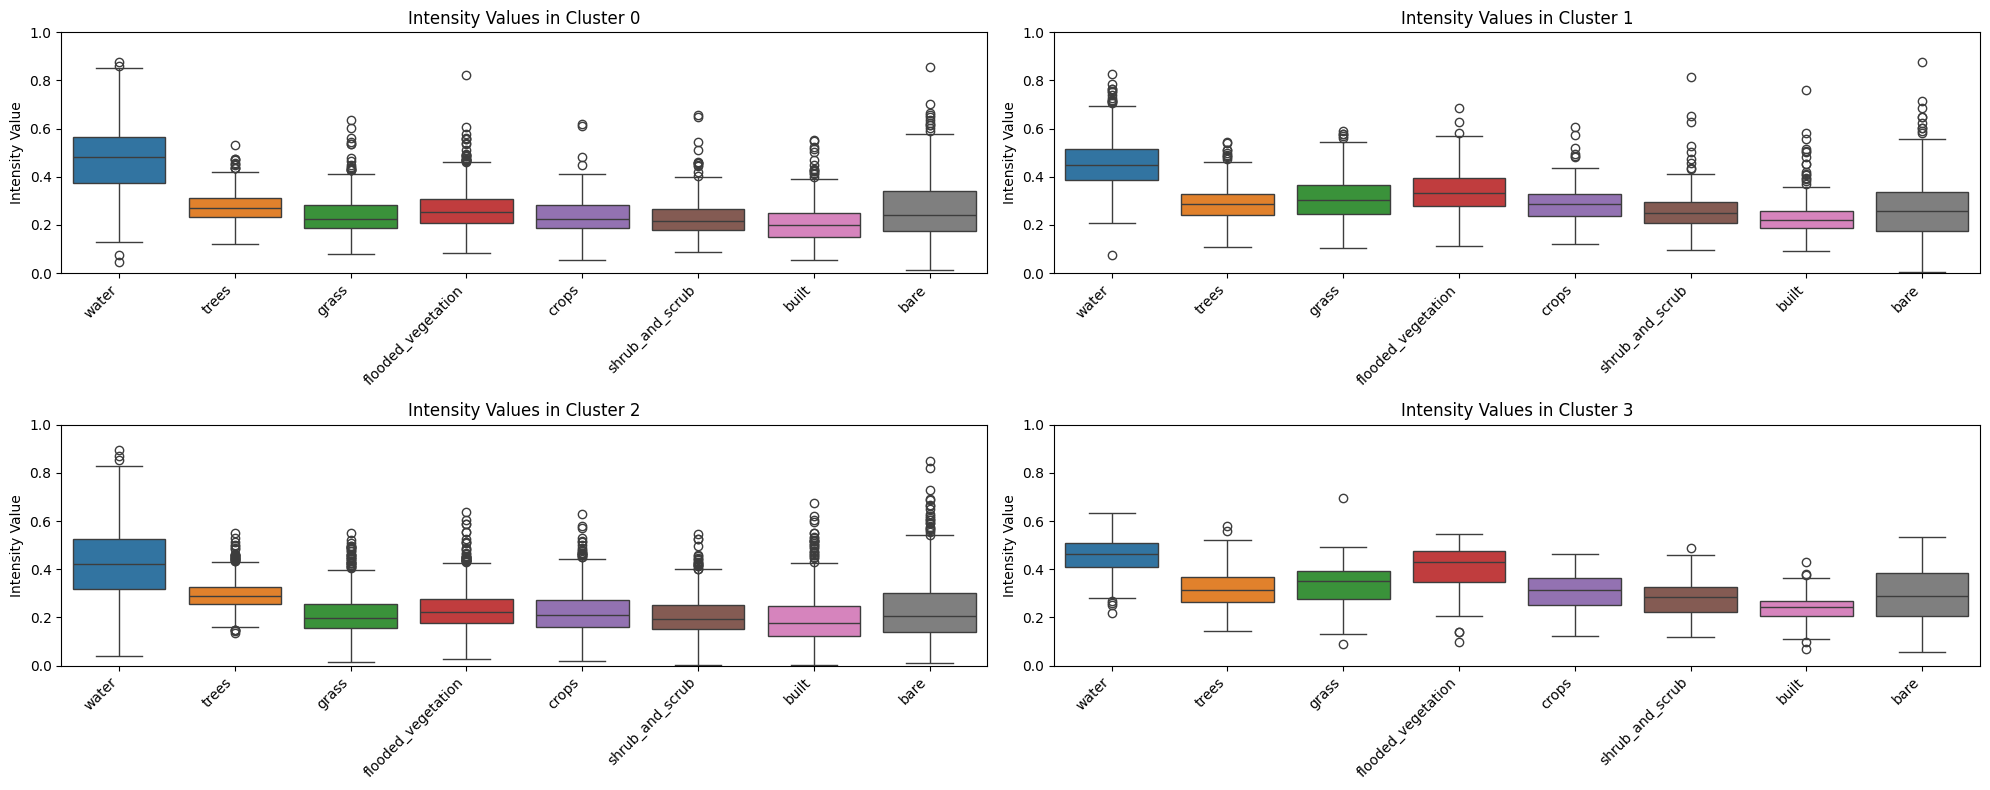

In [14]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 4 * num_rows))  # Adjust the height based on the number of rows

# Iterate through each cluster
for cluster_id in range(k):
    plt.subplot(num_rows, num_columns, cluster_id + 1)
    cluster_data = unbalanced_cluster[unbalanced_cluster['cluster'] == cluster_id]
    sns.boxplot(data=cluster_data[categories])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Intensity Values in Cluster {cluster_id}')
    plt.ylabel('Intensity Value')
    plt.ylim(0,1)
    plt.tight_layout()

plt.show()

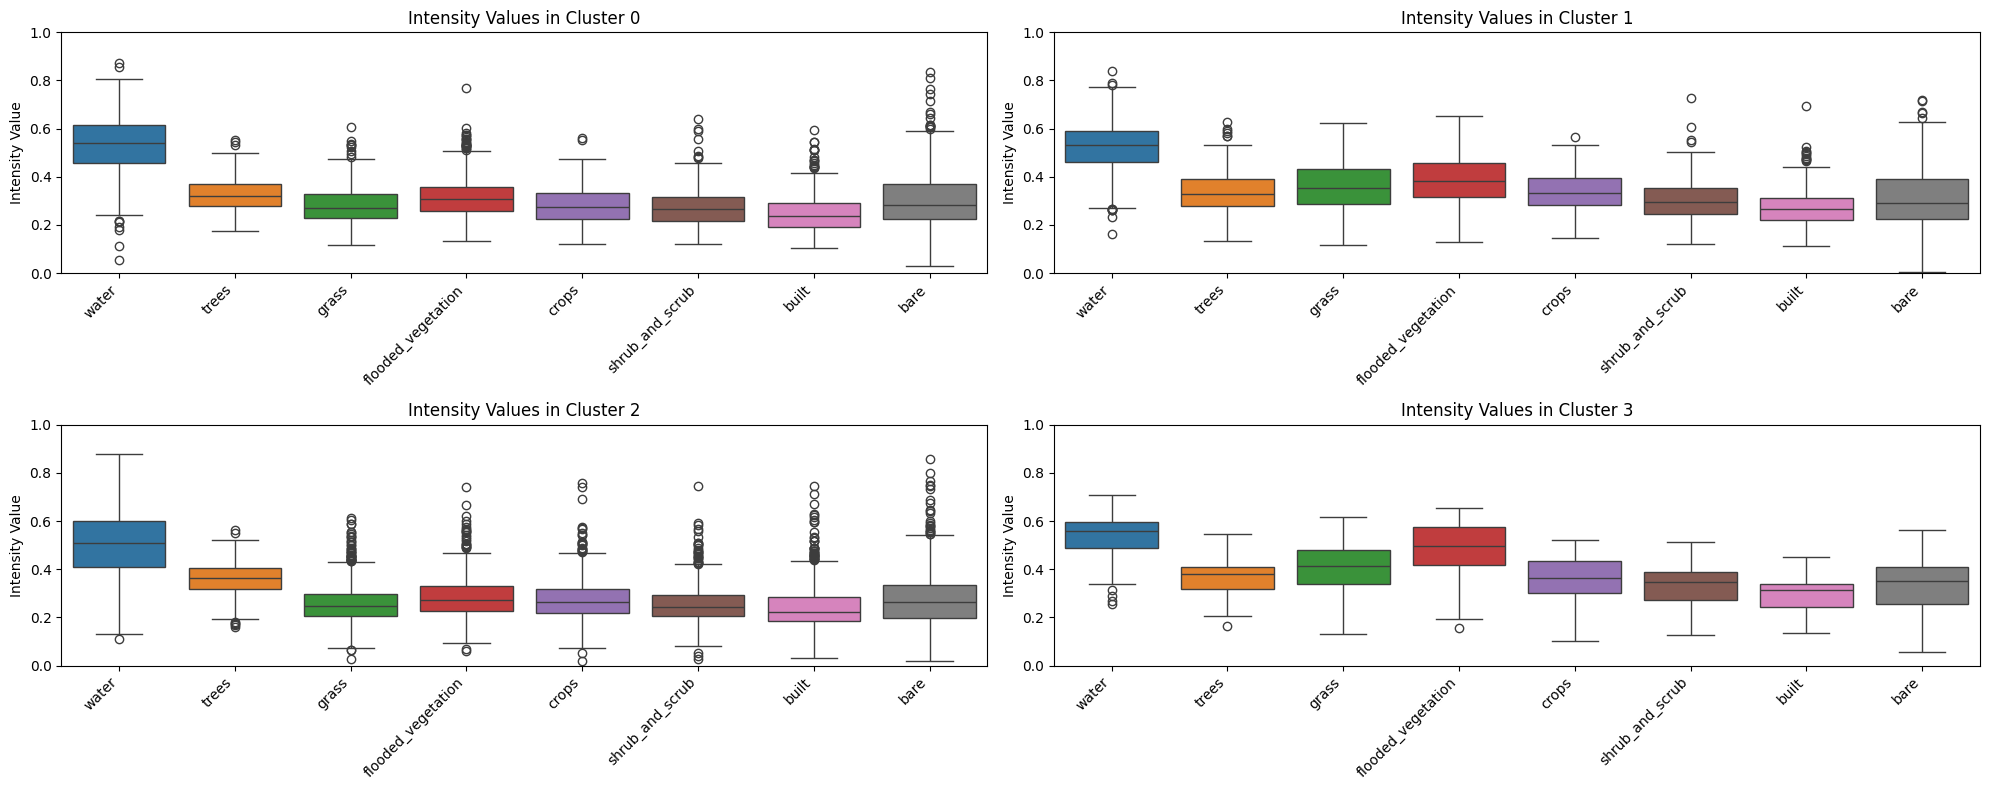

In [15]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 4 * num_rows))  # Adjust the height based on the number of rows

# Iterate through each cluster
for cluster_id in range(k):
    plt.subplot(num_rows, num_columns, cluster_id + 1)
    cluster_data = balanced_cluster[balanced_cluster['cluster'] == cluster_id]
    sns.boxplot(data=cluster_data[categories])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Intensity Values in Cluster {cluster_id}')
    plt.ylabel('Intensity Value')
    plt.ylim(0,1)
    plt.tight_layout()
plt.show()

In [16]:
from scipy.stats import f_oneway

In [17]:
# Function to perform ANOVA across clusters for a given DataFrame
def perform_anova(df):
    results = {}
    for category in categories:
        groups = [df[df['cluster'] == cluster][category].dropna() for cluster in df['cluster'].unique()]
        f_val, p_val = f_oneway(*groups)
        results[category] = {'F-Value': f_val, 'p-Value': p_val}
    return results

# Perform ANOVA for the unbalanced model
unbalanced_results = perform_anova(unbalanced_cluster)
print("ANOVA Results for Unbalanced Model:")
print(pd.DataFrame(unbalanced_results))

# Perform ANOVA for the balanced model
balanced_results = perform_anova(balanced_cluster)
print("ANOVA Results for Balanced Model:")
print(pd.DataFrame(balanced_results))

ANOVA Results for Unbalanced Model:
                water         trees          grass  flooded_vegetation  \
F-Value  1.086022e+01  1.511535e+01   1.842339e+02        2.196226e+02   
p-Value  4.522431e-07  9.854850e-10  7.499572e-106       1.528150e-123   

                crops  shrub_and_scrub         built      bare  
F-Value  9.349112e+01     5.919549e+01  1.726754e+01  7.658772  
p-Value  1.012379e-56     1.029823e-36  4.546996e-11  0.000045  
ANOVA Results for Balanced Model:
            water         trees          grass  flooded_vegetation  \
F-Value  5.757168  3.739483e+01   2.082368e+02        2.550294e+02   
p-Value  0.000644  1.552882e-23  5.336581e-118       1.214088e-140   

                crops  shrub_and_scrub         built      bare  
F-Value  1.010288e+02     6.387437e+01  2.085943e+01  6.927549  
p-Value  5.243010e-61     1.694631e-39  2.642713e-13  0.000126  
